In [102]:
from qutip import *
from sympy import S
# from sympy.physics.wigner import clebsch_gordan 
import numpy as np
from numpy import pi 
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

# Four Qubit Absorbtion of One Photon

As an extension to Garziano et al's simulation of two qubits jointly absorbing and emitting a single photon, I performed a simulation and analysis of four qubits interacting with a single cavity photon in the same manner.  The physics for four qubits are very similar the physics for two qubits.  The main differences are the higher energy averted crossing between ground and excited states, and the corresponding higher energy cavity photon.

In [135]:
#Define cavity parameters
wq = 1 #Hz
wclist = np.linspace(3.75, 4.25, 1000) # wc frequency range
lbda = 0.4*wq #Hz
theta = np.pi/6.
mu = .03
N = 5

# Pre-compute operators for the hamiltonian
a   = tensor(qeye(2), qeye(2), qeye(2), qeye(2), destroy(N))

sz1 = tensor(-1*sigmaz(), qeye(2), qeye(2), qeye(2), qeye(N))
sz2 = tensor(qeye(2), -1*sigmaz(), qeye(2), qeye(2), qeye(N))
sz3 = tensor(qeye(2), qeye(2), -1*sigmaz(), qeye(2), qeye(N))
sz4 = tensor(qeye(2), qeye(2), qeye(2), -1*sigmaz(), qeye(N))

sx1 = tensor(sigmax(), qeye(2), qeye(2), qeye(2), qeye(N))
sx2 = tensor(qeye(2), sigmax(), qeye(2), qeye(2), qeye(N))
sx3 = tensor(qeye(2), qeye(2), sigmax(), qeye(2), qeye(N))
sx4 = tensor(qeye(2), qeye(2), qeye(2), sigmax(), qeye(N))

sm1 = tensor(destroy(2), qeye(2), qeye(2), qeye(2), qeye(N))
sm2 = tensor(qeye(2), destroy(2), qeye(2), qeye(2), qeye(N))
sm3 = tensor(qeye(2), qeye(2), destroy(2), qeye(2), qeye(N))
sm4 = tensor(qeye(2), qeye(2), qeye(2), destroy(2), qeye(N))

sumsz = sz1+sz2+sz3+sz4
sumsx = sx1+sx2+sx3+sx4

In [136]:
def compute_eigs(wclist, lbda, wq, theta, N, Hcase):
    evals_mat = np.zeros((len(wclist),2*2*2*2*N))
    H = 0
    idx = 0
    for wc in wclist:
        # evaluate the Hamiltonian
        if(Hcase == 0):#basic
            H = 0.5*sumsz + wc*a.dag()*a + lbda/wq*(a.dag()+a)*(np.cos(theta)*sumsx+np.sin(theta)*sumsz)
        if(Hcase == 1): #nonlinear term added
            H0 = 0.5*sumsz + wc*a.dag()*a + lbda/wq*(a.dag()+a)*(np.cos(theta)*(sumsx)+np.sin(theta)*(sumsz))
            Hk = (1/wq)*mu*a.dag()*a.dag()*a*a
            H = H0+Hk
        # find the energy eigenvalues of the composite system
        evals, ekets = H.eigenstates()
        evals_mat[idx,:] = np.real(evals)
        idx += 1
    return evals_mat, evals, ekets, H

def compute_freqs(evals_mat):
    w65diff= np.abs(np.subtract(evals_mat[:,16],evals_mat[:,15]))
    w65 = np.amin(w65diff) #frequency splitting
    minindex = np.argmin(w65diff)
    wc65 = wclist[minindex]
    wd = (np.subtract(evals_mat[minindex,16],evals_mat[minindex,0])+np.subtract(evals_mat[minindex,15],evals_mat[minindex,0]))/2
    return w65, wc65, wd

In [137]:
evals_mat1, evals1, ekets1, H1 = compute_eigs(wclist, lbda, wq, theta, N, 1)
w65, wc65, wd = compute_freqs(evals_mat1)
print(w65)
print(wc65)
print(wd)

0.0019029051503378636
3.9772272272272273
4.04110659997108


### Eigenvalues and Avoided Crossing

Below, I plot the first nine eigenvalues of the four qubit hamiltonian as a function of normalized cavity frequency.   Shown below is a detail view of the averted level crossing between eigenstates $|15\rangle$ and $|16\rangle$.  I chose this crossing because it is at almost exactly twice the energy of the crossing between eigenstates $|3\rangle$ and $|4\rangle$ in the two qubit case.  This is to be expected because driving four qubits into their excited state should require a photon with twice the frequency of that required to excite two qubits.  

The averted crossing of these eigenstates are of interest because it likely represents hybridization of the states $|g,g,1\rangle$ and $|e,e,0\rangle$, which enables joint absorbtion of one photon by four qubits.  

(3.97, 3.985)

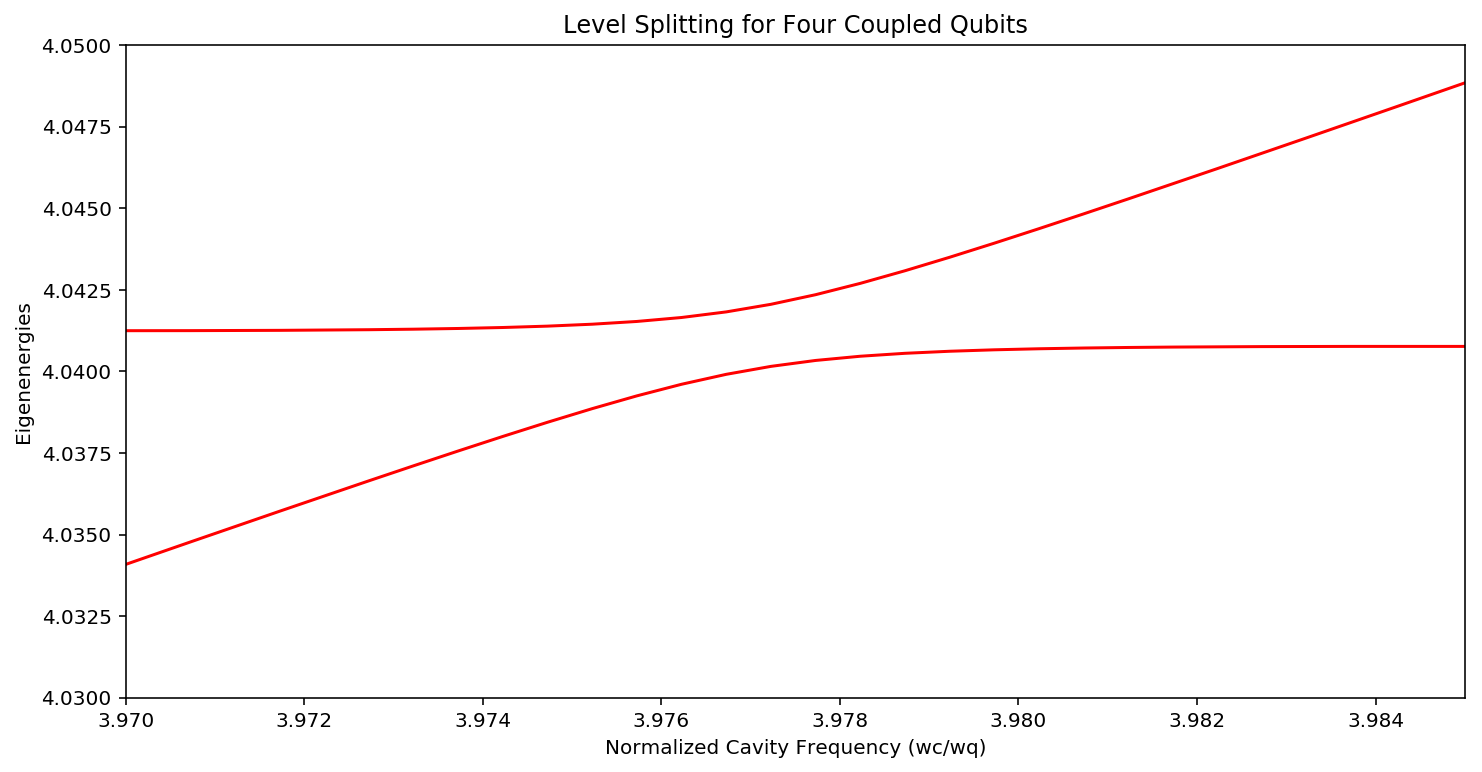

In [154]:
fig, ax = plt.subplots(figsize=(12,6))

for n in range(0,17):
    ax.plot(wclist, (evals_mat1[:,n]-evals_mat1[:,0]) , 'r')

ax.set_xlabel('Normalized Cavity Frequency (wc/wq)')
ax.set_ylabel('Eigenenergies')
ax.set_title('Level Splitting for Four Coupled Qubits');

In [139]:
def eps(t, args):
    w65 = args['w65'] 
    wd = args['wd']
    A = args['A']
    tau = 1/(4*w65)
    t_0 = 0
    return A*np.exp(-((t - t_0)**2.0)/(2.0*tau**2.0))/(tau*np.sqrt(2*pi))*np.cos(wd*t)

def xplus(ekets):
    a   = tensor(qeye(2), qeye(2), destroy(N))
    xp = 0
    for i in range(0, len(ekets)):
        for n in range(15,17):
            j = ekets[i]
            k = ekets[n]
            if(n>i):
                xp = xp + (a.dag()+a).matrix_element(j,k)*j*k.dag()
    return xp

def cplus(ekets, sm):
    cp = 0
    for i in range(0, len(ekets)):
        for n in range(0, len(ekets)):
            j = ekets[i]
            k = ekets[n]
            if(n>i):
                cp = cp + (sm+sm.dag()).matrix_element(j,k)*j*k.dag()
    return cp

In [142]:
#calculate mesolve arguments
A = 6

rho0 = tensor(basis(2,0), basis(2,0), basis(2,0), basis(2,0), fock(N,0))

H0 = 0.5*sumsz + wc65*a.dag()*a + lbda/wq*(a.dag()+a)*(np.cos(theta)*(sumsx)+np.sin(theta)*(sumsz))
Hk = (1/wq)*mu*a.dag()*a.dag()*a*a
H = H0+Hk

evals3, ekets3 = H.eigenstates() 

cp1 = cplus(ekets3, sm1)
cp2 = cplus(ekets3, sm2)
cp3 = cplus(ekets3, sm3)
cp4 = cplus(ekets3, sm4)
xp = xplus(ekets3)

omegaeff = w65/2.
tlist = np.linspace(0, 3*np.pi/omegaeff, 2000)

Hd = (1/wq)*(a.dag()+a)
Hsolve = [H0+Hk, [Hd, eps]]
args = {'w65':w65, 'wd':wd, 'A':A}

cp1exp = cp1.dag()*cp1
cp2exp = cp2.dag()*cp2
cp3exp = cp3.dag()*cp3
cp4exp = cp4.dag()*cp4

In [157]:
result = mesolve(Hsolve, rho0, tlist, [], [xp.dag()*xp, cp1exp, cp2exp, cp3exp, cp4exp, cp1exp*cp2exp*cp3exp*cp4exp], args,progress_bar=ui.TextProgressBar())

10.0%. Run time:   2.45s. Est. time left: 00:00:00:22
20.0%. Run time:   4.87s. Est. time left: 00:00:00:19
30.0%. Run time:   7.28s. Est. time left: 00:00:00:16
40.0%. Run time:   9.63s. Est. time left: 00:00:00:14
50.0%. Run time:  12.08s. Est. time left: 00:00:00:12
60.0%. Run time:  14.56s. Est. time left: 00:00:00:09
70.0%. Run time:  16.95s. Est. time left: 00:00:00:07
80.0%. Run time:  19.29s. Est. time left: 00:00:00:04
90.0%. Run time:  21.70s. Est. time left: 00:00:00:02
Total run time:  23.95s


### Non-dispersive Time-evolution of a Four Qubit System

As in the two qubit case, I calculate the non-dispersive evolution of the cavity system, using a hamiltonian with a Kerr nonlinearity for the purpose of widening energy level gaps.  

The cavity system is initially excited by a laser pulse with drive frequency $w_d = \frac{w_{16}+w_{15}}{2}$. This drives a transition between $|15\rangle$ and $|16\rangle$, that will be visible in the time-dependent solutions for $\langle X^-X^+\rangle$, $\langle C_i^-C_i^+\rangle$, which are respectively the expected photon population in the cavity, and the expected excited state populations for qubits 1-4. 

The time-evolution of these expectation values is plotted below, along with the two qubit correlation function $\langle \prod C_i^-C_i^+ \rangle$.  The impact of the laser pulse is visible at $t=0$, when the photon population of the cavity is driven to approximately 1. At time $t=\pi/4$ later, the photon has been jointly absorbed by the four qubits, which now all populate their excited states.  

The correlation function $\langle \prod C_i^-C_i^+ \rangle$ overlaps fairly well with the qubit population expectations $\langle C_i^-C_i^+\rangle$, indicating that the qubits are well correlated in their behavior. 

For $t>\pi/2$, the qubits continue to jointly emit and then absorb a single cavity photon, clearly extending the phenomena described by Garziano et al. in their paper to higher numbers of qubits. Results for a dispersive cavity are replicated and discussed below.  

/Users/benjaminfearon/anaconda/envs/appphys203/lib/python3.5/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


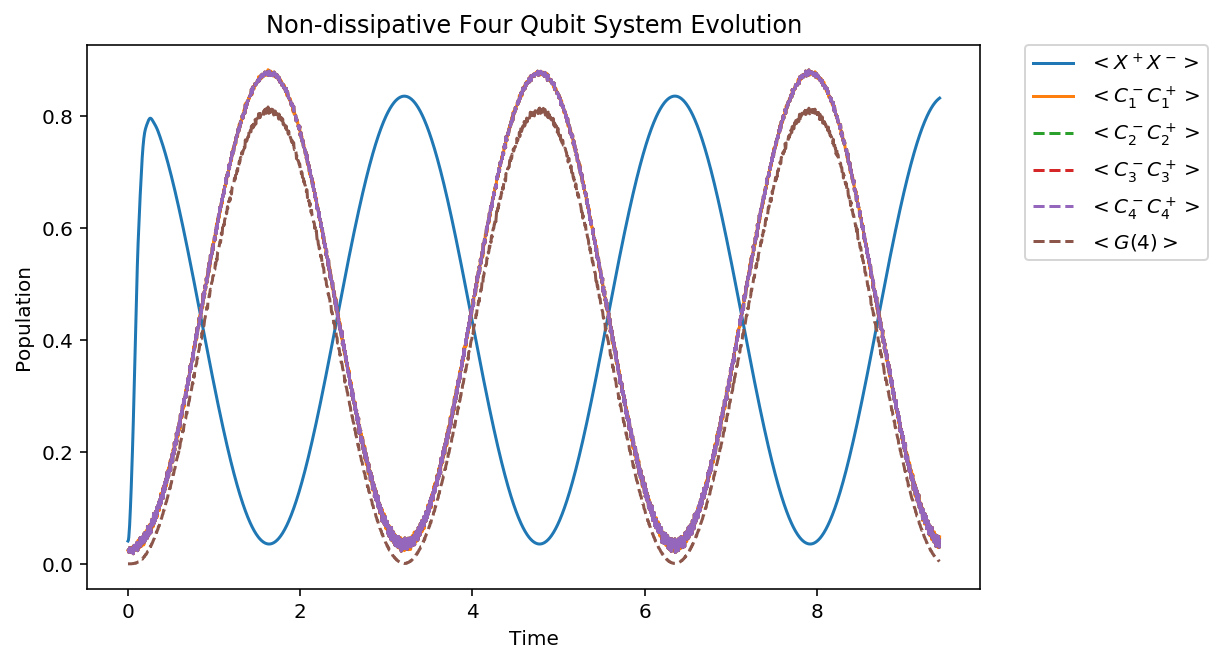

In [165]:
x_expvals = result.expect[0]
c1_expvals = result.expect[1]
c2_expvals = result.expect[2]
c3_expvals = result.expect[3]
c4_expvals = result.expect[4]
corr_expvals = result.expect[5]

#plot the data
fig,ax=plt.subplots(figsize=(8,5))
ax.plot(tlist*omegaeff, x_expvals, label="$<X^+ X^->$")
ax.plot(tlist*omegaeff, c1_expvals, label="$<C_1^- C_1^+>$")
ax.plot(tlist*omegaeff, c2_expvals, '--', label="$<C_2^- C_2^+>$")
ax.plot(tlist*omegaeff, c3_expvals, '--', label="$<C_3^- C_3^+>$")
ax.plot(tlist*omegaeff, c4_expvals, '--', label="$<C_4^- C_4^+>$")
ax.plot(tlist*omegaeff, corr_expvals, '--', label="$<G(4)>$")
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_xlabel('Time');
ax.set_ylabel('Population');
ax.set_title('Non-dissipative Four Qubit System Evolution');

### Dispersive Time-evolution of a Two Qubit System

Below I calculate the time-evolution of the same photon and qubit population operators, but in a dispersive cavity. I use $\kappa$ and $\gamma$ as estimations of the cavity damping rate, and atomic decay rate, respectively. However, for a four qubit system, this calculation is extremely unweildy.  To decrease the ammount of time required to time-evolve the system, I made a few approximations.  

1) I replaced the unweildy $C^+$ and $X^+$ collapse operators with the matrices $\hat{\sigma}^-_i$ and $\hat{a}$, respectively.  These new collapse operators are much more sparse than their counterparts, and accomplish the same goal of applying dispersive effects to the qubits and photon.  

2) Instead of calculating the expectation value of $G^{(4)}$, the four qubit correlation function, I calculated the expectation of three, two-qubit correlation functions (between qubits 1&2, 2&3, and 3&4).  The two-qubit correlation functions will overestimate the correlation between all four qubits, but will nonetheless give good intuition the time-dependence of qubit correlation. I attempted to estimate the magnitude of $G^{(4)}$ by multiplying two two-qubit correlation functions.  This variable is plotted below as well.  

The result, plotted below, clearly exhibits damping.  As time passes, the two qubit correlation functions decrease at a similar rate to the two-qubit case. The $G^{(4)}$ estimate indicates that the qubits are only ever correlated close to the photon population minimum (in their excited states). 


In [151]:
kappa = 4e-5
gamma = 4e-5

smd1 = np.sqrt(gamma)*sm1
smd2 = np.sqrt(gamma)*sm2
smd3 = np.sqrt(gamma)*sm3
smd4 = np.sqrt(gamma)*sm4

result_d = mesolve(Hsolve, rho0, tlist, [np.sqrt(kappa)*a, smd1, smd2, smd3, smd4], [xp.dag()*xp, cp1exp, cp1exp*cp2exp, cp2exp*cp3exp, cp3exp*cp4exp], args, progress_bar=ui.TextProgressBar())



10.0%. Run time:  75.91s. Est. time left: 00:00:11:23
20.0%. Run time: 170.35s. Est. time left: 00:00:11:21
30.0%. Run time: 264.90s. Est. time left: 00:00:10:18
40.0%. Run time: 358.27s. Est. time left: 00:00:08:57
50.0%. Run time: 478.72s. Est. time left: 00:00:07:58
60.0%. Run time: 619.96s. Est. time left: 00:00:06:53
70.0%. Run time: 755.15s. Est. time left: 00:00:05:23
80.0%. Run time: 890.44s. Est. time left: 00:00:03:42
90.0%. Run time: 1023.70s. Est. time left: 00:00:01:53
Total run time: 1158.61s


/Users/benjaminfearon/anaconda/envs/appphys203/lib/python3.5/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


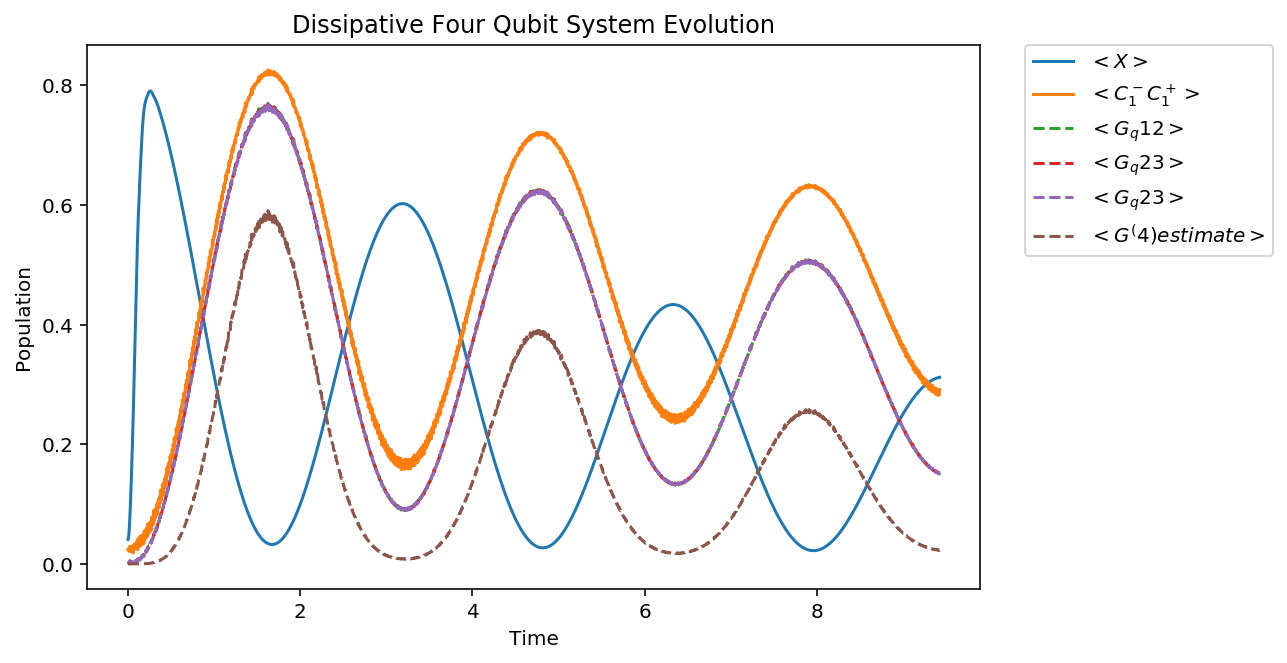

In [167]:
#plot the data
x_expvals_d = result_d.expect[0]
c1_expvals_d = result_d.expect[1]
corr_expvals1_d = result_d.expect[2]
corr_expvals2_d = result_d.expect[3]
corr_expvals3_d = result_d.expect[4]


fig,ax=plt.subplots(figsize=(8,5))
ax.plot(tlist*omegaeff, x_expvals_d, label="$<X>$")
ax.plot(tlist*omegaeff, c1_expvals_d, label="$<C_1^- C_1^+>$")
ax.plot(tlist*omegaeff, corr_expvals1_d, '--', label="$<G_q12>$")
ax.plot(tlist*omegaeff, corr_expvals2_d, '--', label="$<G_q23>$")
ax.plot(tlist*omegaeff, corr_expvals3_d, '--', label="$<G_q23>$")
ax.plot(tlist*omegaeff, corr_expvals3_d*corr_expvals2_d, '--', label="$<G^(4) estimate>$")

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_xlabel('Time');
ax.set_ylabel('Population');
ax.set_title('Dissipative Four Qubit System Evolution');

### Works Cited:

Garziano, L., Macrì, V., Stassi, R., Stefano, O. D., Nori, F., & Savasta, S. (2016). One Photon Can Simultaneously Excite Two or More Atoms. Physical Review Letters, 117(4). doi:10.1103/physrevlett.117.043601